In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import plotly.express as px
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from plotly import graph_objects as go
import math as mth
import seaborn as sns

In [2]:
try:    
    marketing_events = pd.read_csv('C:/Anaconda/Practicum/1 - ab_project_marketing_events.csv')
    events = pd.read_csv("C:/Anaconda/Practicum/1 - final_ab_events.csv")
    new_users = pd.read_csv("C:/Anaconda/Practicum/1 - final_ab_new_users.csv")
    participants = pd.read_csv("C:/Anaconda/Practicum/1 - final_ab_participants.csv")
except:
    marketing_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')
    events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')
    new_users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')
    participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')

Целью данного исследования является проверка эффективности новой рекомендательной системы при помощи а/в теста.
<br>
По сравнению с контрольной группой, предполагается обнаружить разницу в:
- конверсии в просмотр карточек товаров
- просмотры корзины
- покупки

Предобработка
---

In [3]:
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [4]:
marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


Тип данных в столбцах с датами начала и окончания событий можно перевести в datetime

In [5]:
marketing_events[['start_dt', 'finish_dt']] = marketing_events[['start_dt', 'finish_dt']].apply(pd.to_datetime)

In [6]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [7]:
events.sample(10)

,user_id,event_dt,event_name,details
270925,BDC3918961E7862C,2020-12-10 09:46:46,login,NaN
49778,13E70ACD1CCD6159,2020-12-23 13:26:29,purchase,9.99
178915,72BF867AFBD6299D,2020-12-17 11:54:56,product_page,NaN
167122,09BE04C96D815631,2020-12-15 23:39:51,product_page,NaN
231554,AA9A5138437D6A6F,2020-12-24 17:03:29,product_page,NaN
27152,4739F6BC6B18AAB4,2020-12-17 18:31:20,purchase,4.99
89436,E67541944D26ED2D,2020-12-17 18:22:23,product_cart,NaN
148413,9D561774B92F52F8,2020-12-12 15:12:59,product_page,NaN
276982,2F01334D18D17AB3,2020-12-11 14:38:03,login,NaN
193578,AE7A08D166A2EB08,2020-12-19 03:53:17,product_page,NaN


In [8]:
events.duplicated().sum()

0

In [9]:
events.groupby('event_name').agg({'details':'unique'})

,details
event_name,
login,[nan]
product_cart,[nan]
product_page,[nan]
purchase,"[99.99, 9.99, 4.99, 499.99]"


В столбце 'details' присутствует информация только при событии 'purchase', в остальных случаях там пропуск. Столбец с датами также следует перевести в datetime

In [10]:
events['event_dt'] = pd.to_datetime(events['event_dt'])

In [11]:
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [12]:
new_users.sample(10)

,user_id,first_date,region,device
20859,24B6F362D9F33F3D,2020-12-15,N.America,iPhone
25797,3805EB44C7D631A7,2020-12-22,EU,Android
22960,B491A40E527EFBE2,2020-12-15,EU,PC
58008,CC08DF2D2ECFEC7B,2020-12-20,EU,iPhone
17632,45BD2F4A818E0441,2020-12-08,EU,Android
53466,7AA9F4F7F325904A,2020-12-13,N.America,Android
54540,EA91EC51204594F6,2020-12-13,EU,Android
17003,9FEB56D93EE0955E,2020-12-21,EU,PC
40739,98D699A0422667FA,2020-12-11,EU,Mac
45262,7E5636353A80A358,2020-12-12,EU,iPhone


In [13]:
new_users.duplicated().sum()

0

In [14]:
new_users['first_date'] = pd.to_datetime(new_users['first_date'])

In [15]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


In [16]:
participants.sample(10)

,user_id,group,ab_test
798,9CC7BABE25F1E408,A,recommender_system_test
2052,13316E208F8C037D,A,recommender_system_test
12587,4D0C0CFFC30F4A38,A,interface_eu_test
3257,A001715AEC2F18D3,A,recommender_system_test
16919,579BA7C34A2F6453,A,interface_eu_test
16182,17BFBC85ABF9AD27,B,interface_eu_test
15108,221DDCDA4ABEB260,A,interface_eu_test
3707,F9C3B261B20FEA4B,A,recommender_system_test
17894,8E7CAFA50BC60141,B,interface_eu_test
17861,F2E87DF1FE515061,A,interface_eu_test


In [17]:
participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

In [18]:
participants.duplicated().sum()

0

In [19]:
participants[['user_id']].duplicated().sum()

1602

Дубликаты в колонке 'user_id' этого датафрейма, очевидно, обусловлены пользователями, попавшими в оба теста

Оценка корректности проведения теста
---

- Посчитаем количество пользователей, попавших одновременно больше, чем в одну группу.

In [20]:
participants.groupby(['user_id', 'ab_test']).agg({'group':'count'}).query('group > 1').sum()

group    0.0
dtype: float64

Пользователей, одновременно попавших в 2 группы одного теста, нет.

- Разделим пользователей на 2 группы по принадлежности к тестовым группам "А" и "В".

In [21]:
exceptions = participants.query('ab_test == "interface_eu_test" and group == "B"')['user_id'].tolist()
test_a = participants.query('ab_test == "recommender_system_test" and group == "A" and user_id not in @exceptions')
test_b = participants.query('ab_test == "recommender_system_test" and group == "B" and user_id not in @exceptions')

- Проверим, к какому региону относятся пользователи.

In [22]:
test_a = test_a.merge(new_users, left_on = 'user_id', right_on = 'user_id', how = 'left')
test_b = test_b.merge(new_users, left_on = 'user_id', right_on = 'user_id', how = 'left')
display(test_a['region'].unique())
display(test_b['region'].unique())

array(['EU', 'N.America', 'APAC', 'CIS'], dtype=object)

array(['EU', 'N.America', 'CIS', 'APAC'], dtype=object)

В тест попали новые пользователи из всех регионов, хотя по заданию нас интересует только EU

In [23]:
test_a = test_a.query('region == "EU"')
test_b = test_b.query('region == "EU"')

Оставили только нужный регион.

In [24]:
test_a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3195 entries, 0 to 3194
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     3195 non-null   object        
 1   group       3195 non-null   object        
 2   ab_test     3195 non-null   object        
 3   first_date  3195 non-null   datetime64[ns]
 4   region      3195 non-null   object        
 5   device      3195 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 174.7+ KB


In [25]:
test_b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2373 entries, 0 to 2372
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     2373 non-null   object        
 1   group       2373 non-null   object        
 2   ab_test     2373 non-null   object        
 3   first_date  2373 non-null   datetime64[ns]
 4   region      2373 non-null   object        
 5   device      2373 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 129.8+ KB


- Проверим долю новых пользователей, попавших в тест, а также их общее количество.

In [26]:
(test_a['user_id'].nunique() + test_b['user_id'].nunique())/new_users[(new_users['first_date'] >= '2020-12-7')&\
        (new_users['first_date'] <= '2020-12-21')&(new_users['region'] == "EU")]['user_id'].nunique()

0.13150684931506848

In [27]:
test_a['user_id'].nunique() + test_b['user_id'].nunique()

5568

В основную и контрольную группу теста попало чуть больше 13% новых пользователей исследуемого региона, что достаточно близко к заданной отметке в 15%.
<br>
Всего в тесте 5568 пользователей.

Для анализа результатов теста нам подходят пользователи, попавшие только в исследуемый тест, а также те, кто попал в контрольную группу конкурирующего теста, так как на их поведение влияет только проверяемый параметр.
<br>
Суммарное количество пользователей, попавших в тест, довольно близко к рассчетному (почти 5600 при заданном значении 6000), но они неравномерно распределены с перевесом в сторону контрольной группы.
<br>
Также следует отметить, что часть времение тестирования пришлась на новогодние праздники и связанное с ними маркетинговое событие. Теоретически, его влияние на увеличение активности в обеих группах должно быть одинаковым.

Исследовательский анализ
---

Добавим к спискам пользователей, попавших в контрольные группы, информацию о событиях

In [28]:
test_a = test_a[['user_id', 'first_date', 'device']].merge(events, left_on = 'user_id', right_on = 'user_id', how = 'left')
test_b = test_b[['user_id', 'first_date', 'device']].merge(events, left_on = 'user_id', right_on = 'user_id', how = 'left')

In [29]:
test_a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17070 entries, 0 to 17069
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     17070 non-null  object        
 1   first_date  17070 non-null  datetime64[ns]
 2   device      17070 non-null  object        
 3   event_dt    16154 non-null  datetime64[ns]
 4   event_name  16154 non-null  object        
 5   details     2240 non-null   float64       
dtypes: datetime64[ns](2), float64(1), object(3)
memory usage: 933.5+ KB


In [30]:
test_b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6012 entries, 0 to 6011
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     6012 non-null   object        
 1   first_date  6012 non-null   datetime64[ns]
 2   device      6012 non-null   object        
 3   event_dt    4410 non-null   datetime64[ns]
 4   event_name  4410 non-null   object        
 5   details     564 non-null    float64       
dtypes: datetime64[ns](2), float64(1), object(3)
memory usage: 328.8+ KB


In [31]:
display(test_a['event_dt'].max())
display(test_b['event_dt'].max())

Timestamp('2020-12-29 23:38:29')

Timestamp('2020-12-30 12:42:57')

Дата последнего действия в каждой группе находится в пределах заданного интервала.
<br>
Следует помнить, что 25-го числа стартовал новогодний эвент, что могло повлиять на активность покупателей.

In [32]:
test_a['time_gap'] = (test_a['event_dt'] - test_a['first_date']).dt.days.fillna(0).astype(int)
test_b['time_gap'] = (test_b['event_dt'] - test_b['first_date']).dt.days.fillna(0).astype(int)
test_a = test_a.query('time_gap < 15')
test_b = test_b.query('time_gap < 15')

Убрали из анализа действия, выполненные позднее 2-х недель после регистрации

In [33]:
display(test_a['user_id'].nunique())
display(test_b['user_id'].nunique())

3195

2373

In [34]:
display(test_a[~test_a['event_name'].isna()]['user_id'].nunique())
display(test_b[~test_b['event_name'].isna()]['user_id'].nunique())

2279

771

В группе "А" осталось 3195 участников, из которых 2279 совершили какой-либо действие в рассматриваемый период.
<br>
В группе "В" - 2373 участника, действия совершали только 771 из них.

In [35]:
a_pivot = test_a.pivot_table(index = 'user_id', columns = 'event_name', values = 'event_dt', aggfunc = 'count', fill_value = 0)
b_pivot = test_b.pivot_table(index = 'user_id', columns = 'event_name', values = 'event_dt', aggfunc = 'count', fill_value = 0)

In [36]:
a_pivot['activity'] = a_pivot.sum(axis = 1)
b_pivot['activity'] = b_pivot.sum(axis = 1)
a_grouped = test_a.groupby('user_id').agg({'details':'sum'})
b_grouped = test_b.groupby('user_id').agg({'details':'sum'})
a_pivot = pd.merge(a_pivot, a_grouped, on = 'user_id', how = 'inner')
b_pivot = pd.merge(b_pivot, b_grouped, on = 'user_id', how = 'inner')

Подготовили данные к анализу активности пользователей

In [37]:
b_pivot.query('login == 0')

,login,product_cart,product_page,purchase,activity,details
user_id,,,,,,
5FF8B6AB257B404F,0,0,0,1,1,4.99


In [38]:
b_pivot = b_pivot.query('login != 0')

Похоже на ошибку записи, уберем из анализа

In [39]:
test_a['m_event'] = test_b['m_event'] = 0
for index, m_event in marketing_events.iterrows():
    test_a['m_event'].mask((test_a['event_dt'] >= m_event['start_dt'])&(test_a['event_dt'] <= m_event['finish_dt'])&\
                             ('EU' in m_event['regions'].split(sep = ',')),1,inplace = True)
    test_b['m_event'].mask((test_b['event_dt'] >= m_event['start_dt'])&(test_b['event_dt'] <= m_event['finish_dt'])&\
                             ('EU' in m_event['regions'].split(sep = ',')),1,inplace = True)

In [40]:
display(test_a['m_event'].sum())
display(test_b['m_event'].sum())

2101

279

Добавили столбец с меткой о совпадении события пользователя с маркетинговой кампанией.
<br>
Таких записей 2101 в группе "А" и 279 в группе "В"

**Сравнение групп**

In [41]:
a_pivot['group'] = 'A'
b_pivot['group'] = 'B'
com_pivot = pd.concat([a_pivot, b_pivot])

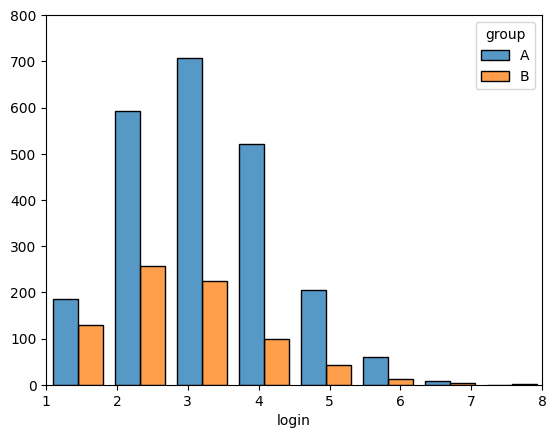

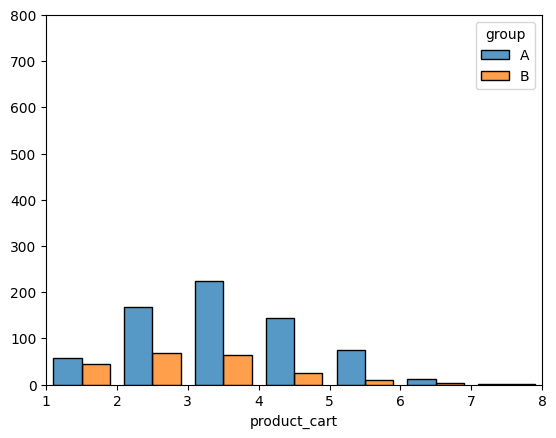

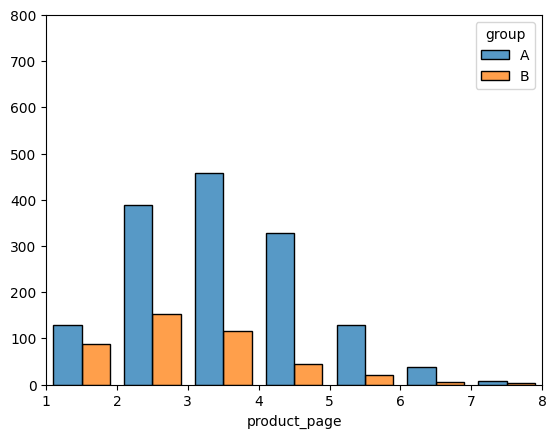

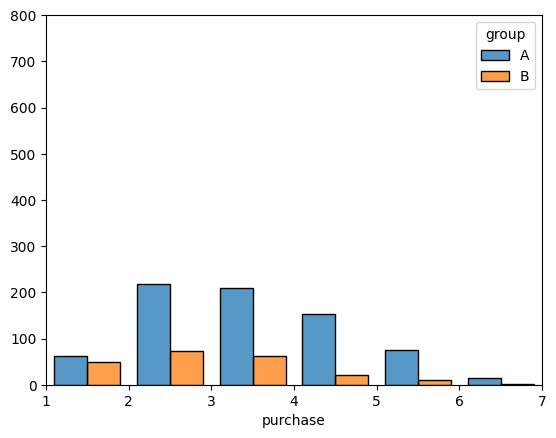

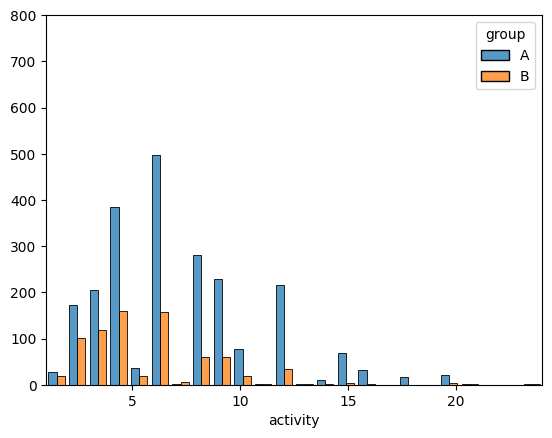

In [42]:
for i, action in enumerate(com_pivot.columns[:5]):
    plt.figure(i)
    plt.xlim(1, com_pivot[action].max())
    plt.ylim(0, 800)
    fig = sns.histplot(data = com_pivot, x = com_pivot[action], hue = 'group', bins = com_pivot[action].max(),\
                       multiple = 'dodge', shrink=.8)
    fig.set(ylabel = None)

In [43]:
for event in ['login', 'product_page', 'product_cart', 'purchase']:
    a_event = test_a.query('event_name == @event').groupby('user_id').agg({'event_name':'count'})['event_name']
    b_event = test_b.query('event_name == @event').groupby('user_id').agg({'event_name':'count'})['event_name']
    print('Cобытие: ', event)
    print('Группа А: среди совершавших действие - {0}, среди всех пользователей - {1}'.\
          format(a_event.mean().round(3), (a_event.sum()/test_a[~test_a['event_name'].isna()]['user_id'].nunique()).round(3)))
    print('Группа B: среди совершавших действие - {0}, среди всех пользователей - {1}'.\
          format(b_event.mean().round(3), (b_event.sum()/test_b[~test_b['event_name'].isna()]['user_id'].nunique()).round(3)))

Cобытие:  login
Группа А: среди совершавших действие - 3.079, среди всех пользователей - 3.079
Группа B: среди совершавших действие - 2.644, среди всех пользователей - 2.641
Cобытие:  product_page
Группа А: среди совершавших действие - 3.058, среди всех пользователей - 1.981
Группа B: среди совершавших действие - 2.503, среди всех пользователей - 1.393
Cобытие:  product_cart
Группа А: среди совершавших действие - 3.082, среди всех пользователей - 0.928
Группа B: среди совершавших действие - 2.533, среди всех пользователей - 0.703
Cобытие:  purchase
Группа А: среди совершавших действие - 3.004, среди всех пользователей - 0.968
Группа B: среди совершавших действие - 2.425, среди всех пользователей - 0.689


Можно отметить, что активность пользователей из контрольной группы заметно выше, чем в исследуемой.
<br>
Это проявляется на всех этапах - от количества логинов до количества покупок

**Оценка активности пользователей по дням**

In [44]:
test_a['event_dt'] = test_a['event_dt'].dt.normalize()
test_b['event_dt'] = test_b['event_dt'].dt.normalize()

In [45]:
a_daily = test_a.groupby('event_dt').agg({'event_name':'count', 'm_event':'max'}).reset_index()
b_daily = test_b.groupby('event_dt').agg({'event_name':'count', 'm_event':'max'}).reset_index()

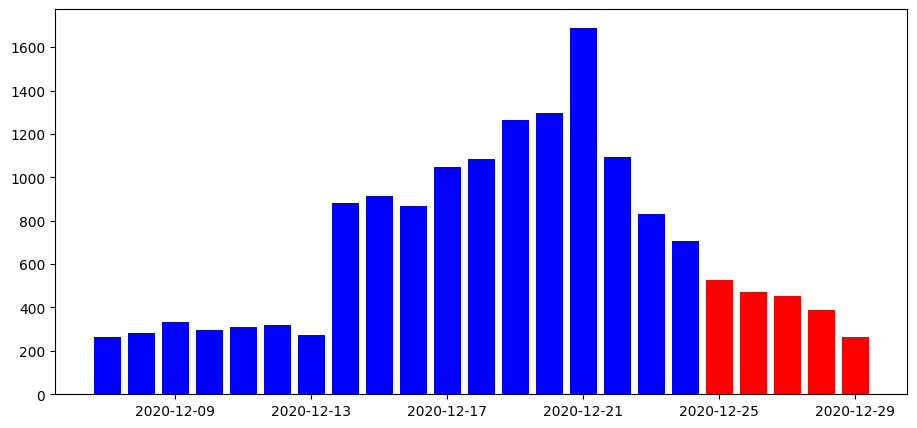

In [46]:
plt.rcParams["figure.figsize"] = (11,5)
clrs = ['blue' if x == 0 else 'red' for x in a_daily['m_event']]
fig = plt.bar(x = a_daily['event_dt'], height = a_daily['event_name'], color = clrs);

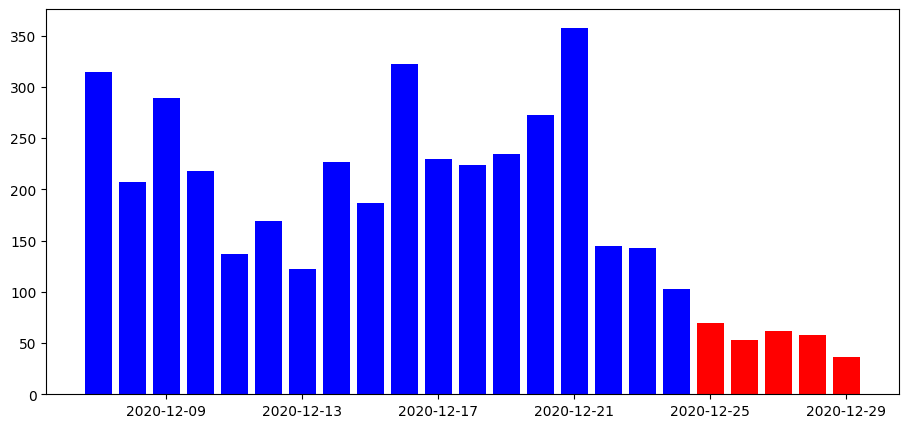

In [47]:
clrs = ['blue' if x == 0 else 'red' for x in b_daily['m_event']]
fig = plt.bar(x = b_daily['event_dt'], height = b_daily['event_name'], color = clrs);

На обоих графиках общей активности отмечается выраженная просадка в праздничные дни.

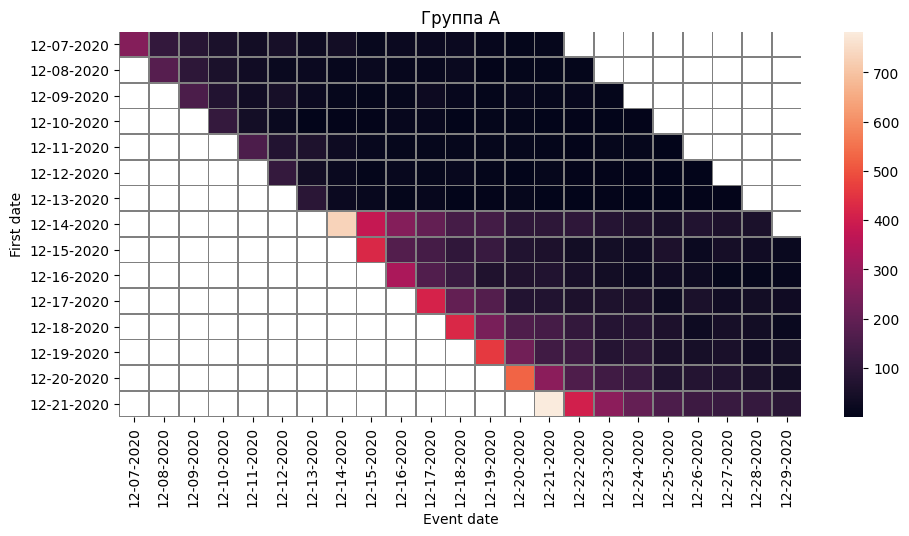

In [90]:
cohort_a = test_a.pivot_table(index = 'first_date', columns = 'event_dt', values = 'event_name', aggfunc = 'count')
fig, ax = plt.subplots()
fig = sns.heatmap(cohort_a, linewidth = .5, linecolor = 'gray')
x_dates = cohort_a.columns.strftime('%m-%d-%Y')
y_dates = cohort_a.index.strftime('%m-%d-%Y')
ax.set_xticklabels(labels = x_dates)
ax.set_yticklabels(labels = y_dates)
plt.title('Группа А')
plt.xlabel('Event date')
plt.ylabel('First date');

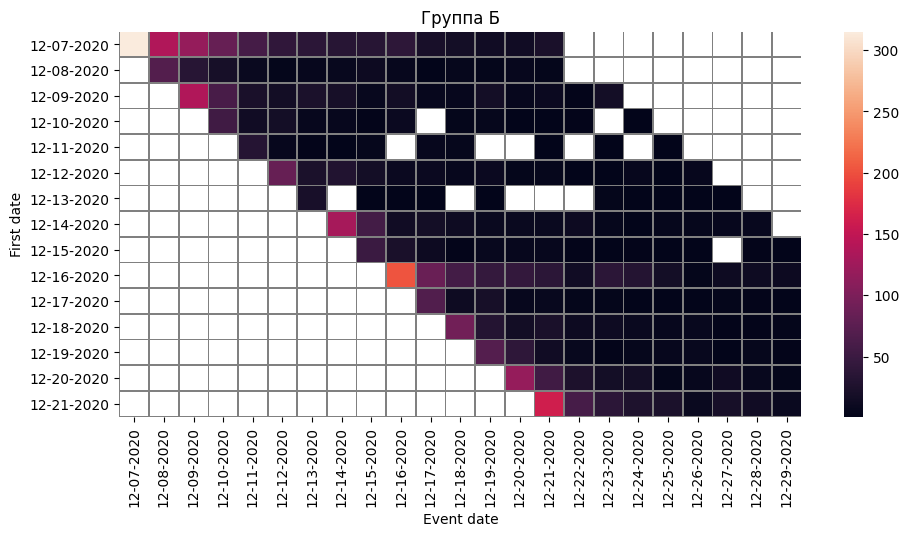

In [91]:
cohort_b = test_b.pivot_table(index = 'first_date', columns = 'event_dt', values = 'event_name', aggfunc = 'count')
fig, ax = plt.subplots()
fig = sns.heatmap(cohort_b, linewidth = .5, linecolor = 'gray')
x_dates = cohort_b.columns.strftime('%m-%d-%Y')
y_dates = cohort_b.index.strftime('%m-%d-%Y')
ax.set_xticklabels(labels = x_dates)
ax.set_yticklabels(labels = y_dates)
plt.title('Группа Б')
plt.xlabel('Event date')
plt.ylabel('First date');

По тепловой карте для контрольной группы можно видеть, что наибольшая активность у пользователей отмечается в первые дни после установки приложения, после чего плавно снижается.
<br>
В исследуемой группе относительная активность даже в первые дни ниже, кроме того, наблюдаются провалы для некоторых дней с полным отсутствием активности.

In [50]:
funnel_a = test_a.groupby('event_name').agg({'user_id':'nunique'})\
        .loc[['login', 'product_page', 'product_cart', 'purchase']].reset_index()
funnel_b = test_b.groupby('event_name').agg({'user_id':'nunique'})\
        .loc[['login', 'product_page', 'product_cart', 'purchase']].reset_index()

In [51]:
fig = go.Figure()
fig.add_trace(go.Funnel(name = 'Группа А', y = funnel_a['event_name'], x = funnel_a['user_id'], textinfo = "value+percent initial"))
fig.add_trace(go.Funnel(name = 'Группа В', y = funnel_b['event_name'], x = funnel_b['user_id'], textinfo = "value+percent initial"))

Продуктовая воронка показывает то же самое, что и расчеты: конверсия в каждый следующий шаг для исследуемой группы хуже, чем для контрольной.

Оценка результатов
---

**Проверка конверсии z-критерием**

In [52]:
z_test = funnel_a.merge(funnel_b, on = 'event_name', suffixes = ('_a', '_b'))
for index, action in z_test.iloc[1:].iterrows():
    p1 = z_test[z_test['event_name'] == action['event_name']]['user_id_a'][index] /\
        z_test[z_test['event_name'] == 'login']['user_id_a'][0]
    p2 = z_test[z_test['event_name'] == action['event_name']]['user_id_b'][index] /\
        z_test[z_test['event_name'] == 'login']['user_id_b'][0]
    p_combined = z_test[z_test['event_name'] == action['event_name']].sum(axis = 1)[index] /\
        z_test[z_test['event_name'] == 'login'].sum(axis = 1)[0]
    diff = p1 - p2
    z_value = diff / mth.sqrt(p_combined * (1 - p_combined) * (1/z_test[z_test['event_name'] == 'login']['user_id_a'][0]\
                                            + 1/z_test[z_test['event_name'] == 'login']['user_id_b'][0]))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('Для события {0} p_value = {1:.3f}'.format(action['event_name'], p_value))

Для события product_page p_value = 0.000
Для события product_cart p_value = 0.225
Для события purchase p_value = 0.051


Доли в основной и контрольной группах различаются, хотя уровень значимости для покупок находится на минимальном значении.
<br>
Из-за возможности покупок в 1 клик доли просмотров корзины нас мало интересуют, тем не менее, даже там исследуемая группа отстает от контрольной, пусть и не так заметно.

**Общий вывод**

В первую очередь, следует отметить неудачное время проведения эксперимента - он пришелся на новогодние праздники и на графике активности можно видеть резкий провал в это время. Кроме того под вопросом корректность сбора данных - в обоих группах много пользователей, не совершивших ни одного действия
<br>
Тем не менее, по результатам оценки действий пользователей, попавших в анализируемые данные, можно сделать вывод о неэффективности новой системы рекомендаций - конверсия в исследуемой группе заметно ниже, чем в контрольной.